# Imports

In [21]:
import json
import os
import bz2
import io
from bz2 import BZ2File
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the clean dataset

In [2]:
df = pd.read_json('cleaned.json.bz2', compression = 'bz2')
df['journal'] = df['journal'].astype('category')
df.head()

,id,journal,date,page,ppage,text,length
0,0,JDG,1978-12-29,1,NaN,Algérie : l'arbitrage sans arbitre Pour un Eta...,3777
1,1,JDG,1978-12-29,3,NaN,ALORS QUE LA FOULE ENTERRE SES DERNIERES VICTI...,3401
100,100,JDG,1978-06-13,1,NaN,La Ruhr chinoise s'ouvre à l'Occident Gilbert ...,6017
10000,10000,JDG,1978-10-25,11,NaN,Selon le président du directoire de la Banque ...,4345
100000,100000,GDL,1976-10-05,2,NaN,TÉLÉVISION-RADIO SELECTION-TV Antenne 2 20.30 ...,7976


In [3]:
df = df.drop(columns = 'id')

In [4]:
df.index = np.arange(len(df))

# Filter the dataset with keywords

In [5]:
keywords = ['pétrol', 
            'opep', 
            'organisation des pays exportateurs de pétrole',
            'shell',
            'tamoil',
            'petrol',
            'petroleum',
            'texaco',
            'standard oil',
            'exxon',
            'gulf oil',
            'ats',
            'afp',
            'reuther']

In [6]:
def keywords_count(df, keywords):
    """ Select text that contains certain keywords and count the latter """
    
    counts, k = [], []
    
    for keyword in keywords:
        k.append(keyword.lower())
    
    for ind, row in df.iterrows():
        
        counts_ = []
        for k_ in k:
            counts_.append(len(re.findall(k_, row['text'].lower())))
        
        counts.append(counts_)
                
    return counts

In [7]:
counts = keywords_count(df, keywords)
counts = np.asarray(counts).T

In [8]:
for i in range(len(keywords)):
    df['keyword_' + keywords[i]] = counts[i]

In [9]:
df['keywords_petrole'] = df['keyword_pétrol'] + df['keyword_petrol']
df['keywords_OPEP'] = df['keyword_opep'] + \
    df['keyword_organisation des pays exportateurs de pétrole']
df['keywords_compagnies'] = df['keyword_shell'] + \
    df['keyword_tamoil'] + df['keyword_petroleum'] + df['keyword_texaco'] + \
    df['keyword_standard oil'] + df['keyword_exxon'] + df['keyword_gulf oil']
df['keywords'] = df['keywords_petrole'] + df['keywords_OPEP'] + \
    df['keywords_compagnies']

df['depeches'] = df['keyword_afp'] + df['keyword_ats'] + df['keyword_reuther']

In [10]:
df_corpus = df[df['keywords'] > 0]
df_corpus_OPEP = df[df['keywords_OPEP'] > 0]
df_corpus_petrole = df[df['keywords_petrole'] > 0]
df_corpus_compagnies = df[df['keywords_compagnies'] > 0]

In [11]:
df_corpus.to_json('corpus.json.bz2', compression = 'bz2')
df_corpus_OPEP.to_json('corpus_OPEP.json.bz2', compression = 'bz2')
df_corpus_petrole.to_json('corpus_petrole.json.bz2', compression = 'bz2')
df_corpus_compagnies.to_json('corpus_compagnies.json.bz2', compression = 'bz2')

In [12]:
len(df_corpus)

31627

In [13]:
len(df_corpus_OPEP)

3172

In [14]:
len(df_corpus_petrole)

29218

In [15]:
len(df_corpus_compagnies)

10560

In [16]:
df_depeches = df_corpus[df_corpus['depeches'] > 0]
df_not_depeches = df_corpus[df_corpus['depeches'] == 0]

In [17]:
df_depeches.to_json('corpus_depeches.json.bz2', compression = 'bz2')
df_not_depeches.to_json('corpus_not_depeches.json.bz2', compression = 'bz2')

In [18]:
len(df_depeches)

24822

In [19]:
len(df_not_depeches)

6805

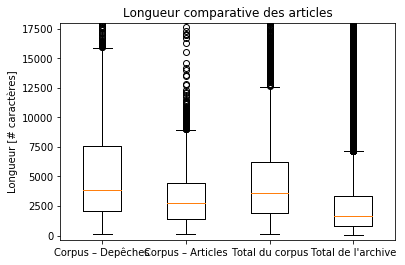

In [22]:
plt.boxplot([np.array(df_depeches['length']), 
             np.array(df_not_depeches['length']),
             np.array(df_corpus['length']),
             np.array(df['length'])]);

plt.xticks([1,2,3,4], np.array(['Corpus – Depêches', 'Corpus – Articles', 
                                'Total du corpus', "Total de l\'archive"]))
plt.ylabel('Longueur [# caractères]');
plt.ylim((-400,18000))
plt.title('Longueur comparative des articles');
plt.show()

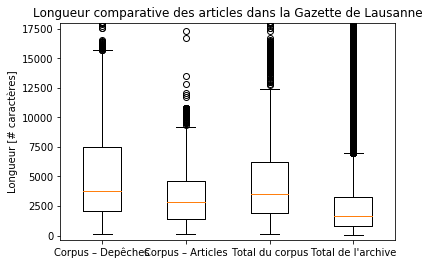

In [23]:
plt.boxplot([np.array(df_depeches[df_depeches['journal'] == 'GDL']['length']), 
             np.array(df_not_depeches[df_not_depeches['journal'] == 'GDL']['length']),
             np.array(df_corpus[df_corpus['journal'] == 'GDL']['length']),
             np.array(df[df['journal'] == 'GDL']['length'])]);

plt.xticks([1,2,3,4], np.array(['Corpus – Depêches', 'Corpus – Articles', 
                                'Total du corpus', "Total de l\'archive"]))
plt.ylabel('Longueur [# caractères]');
plt.ylim((-400,18000))
plt.title('Longueur comparative des articles dans la Gazette de Lausanne');
plt.show()

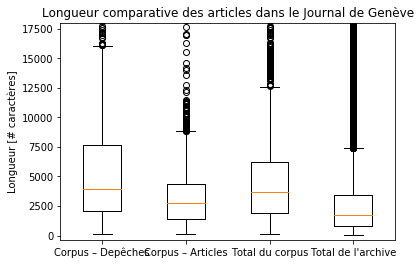

In [24]:
plt.boxplot([np.array(df_depeches[df_depeches['journal'] == 'JDG']['length']), 
             np.array(df_not_depeches[df_not_depeches['journal'] == 'JDG']['length']),
             np.array(df_corpus[df_corpus['journal'] == 'JDG']['length']),
             np.array(df[df['journal'] == 'JDG']['length'])]);

plt.xticks([1,2,3,4], np.array(['Corpus – Depêches', 'Corpus – Articles', 
                                'Total du corpus', "Total de l\'archive"]))
plt.ylabel('Longueur [# caractères]');
plt.ylim((-400,18000))
plt.title('Longueur comparative des articles dans le Journal de Genève');
plt.show()

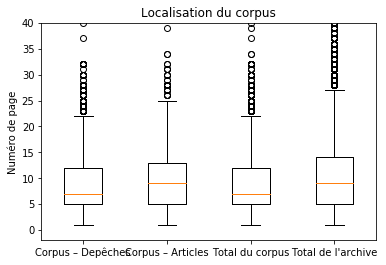

In [25]:
plt.boxplot([(np.append(df_depeches['page'], df_depeches['ppage'].dropna())), 
             (np.append(df_not_depeches['page'], df_not_depeches['ppage'].dropna())),
             (np.append(df_corpus['page'], df_corpus['ppage'].dropna())),
             (np.append(df['page'], df['ppage'].dropna()))]);

plt.xticks([1,2,3,4], np.array(['Corpus – Depêches', 'Corpus – Articles', 
                                'Total du corpus', "Total de l\'archive"]))
plt.ylabel('Numéro de page');
plt.ylim((-2,40))
plt.title('Localisation du corpus');
plt.show()

In [26]:
publication_time = []

for ind, row in df_corpus.iterrows():
    publication_time.append(row['date'].year + row['date'].month/12 - 1/24)
    
df_corpus['publication_time'] = publication_time

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


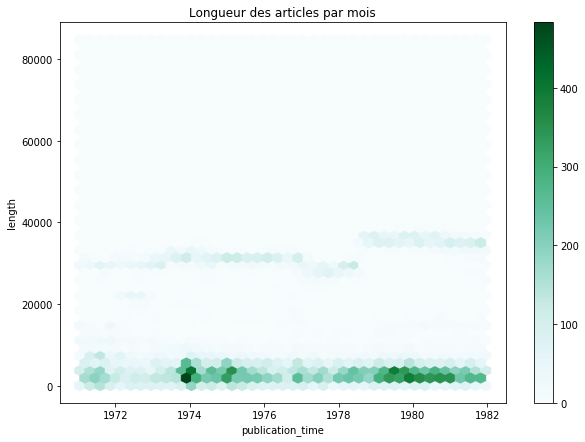

In [27]:
df_corpus.plot(kind='hexbin', x='publication_time', y='length', gridsize=40, 
                title = 'Longueur des articles par mois', figsize=(10,7), sharex=False);

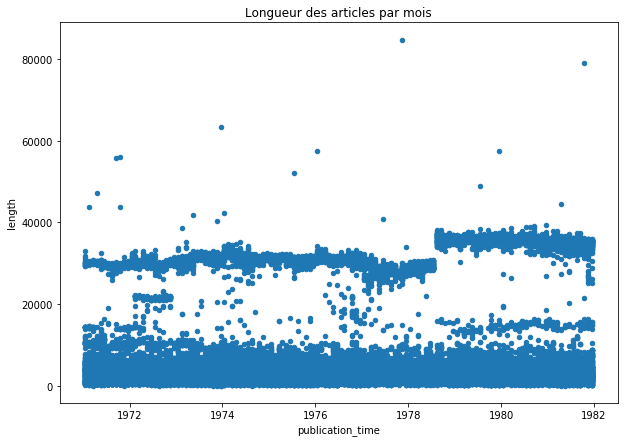

In [28]:
df_corpus.plot(kind='scatter', x='publication_time', y='length', 
                title = 'Longueur des articles par mois', figsize=(10,7), sharex=False);

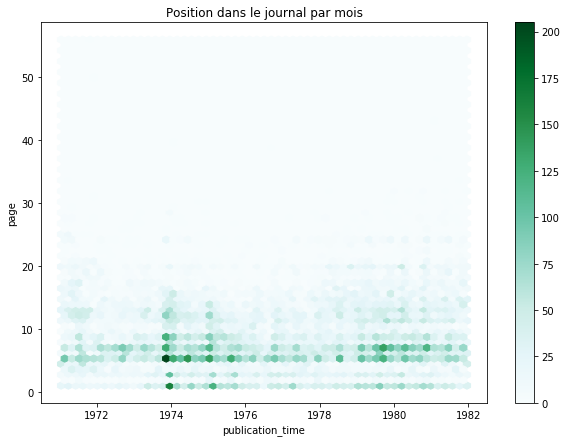

In [29]:
df_corpus.plot(kind='hexbin', x='publication_time', y='page', gridsize=56, 
                title = 'Position dans le journal par mois', figsize=(10,7), sharex=False);

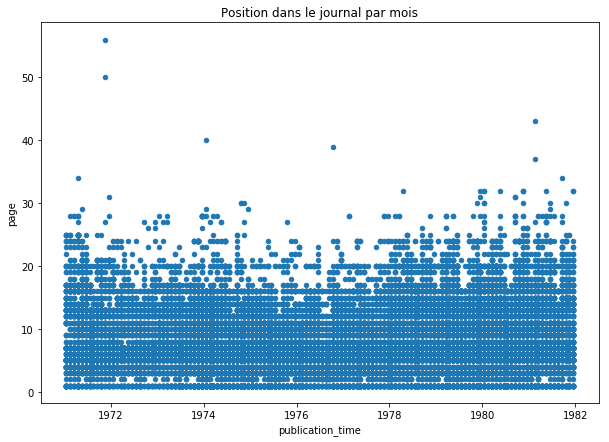

In [30]:
df_corpus.plot(kind='scatter', x='publication_time', y='page', #gridsize=56, 
                title = 'Position dans le journal par mois', figsize=(10,7), sharex=False);

In [31]:
df_corpus_per_month = df_corpus.groupby(['publication_time']).sum()

In [32]:
df_corpus_per_month.head()

,page,ppage,length,keyword_pétrol,keyword_opep,keyword_organisation des pays exportateurs de pétrole,keyword_shell,keyword_tamoil,keyword_petrol,keyword_petroleum,...,keyword_exxon,keyword_gulf oil,keyword_ats,keyword_afp,keyword_reuther,keywords_petrole,keywords_OPEP,keywords_compagnies,keywords,depeches
publication_time,,,,,,,,,,,,,,,,,,,,,
1971.041667,1749,7.0,1282030,449,79,7,94,0,59,19,...,0,26,309,65,0,508,86,218,812,374
1971.125000,1692,9.0,1168413,527,82,6,89,0,59,26,...,0,15,256,101,0,586,88,196,870,357
1971.208333,1660,25.0,1235834,377,4,2,92,0,60,26,...,0,11,248,90,0,437,6,176,619,338
1971.291667,3194,20.0,1633731,559,7,2,150,0,70,27,...,0,25,305,96,0,629,9,287,925,401
1971.375000,2547,0.0,1363986,265,2,1,134,0,45,5,...,0,38,255,29,0,310,3,247,560,284


In [33]:
df_corpus_per_month['time'] = df_corpus_per_month.index

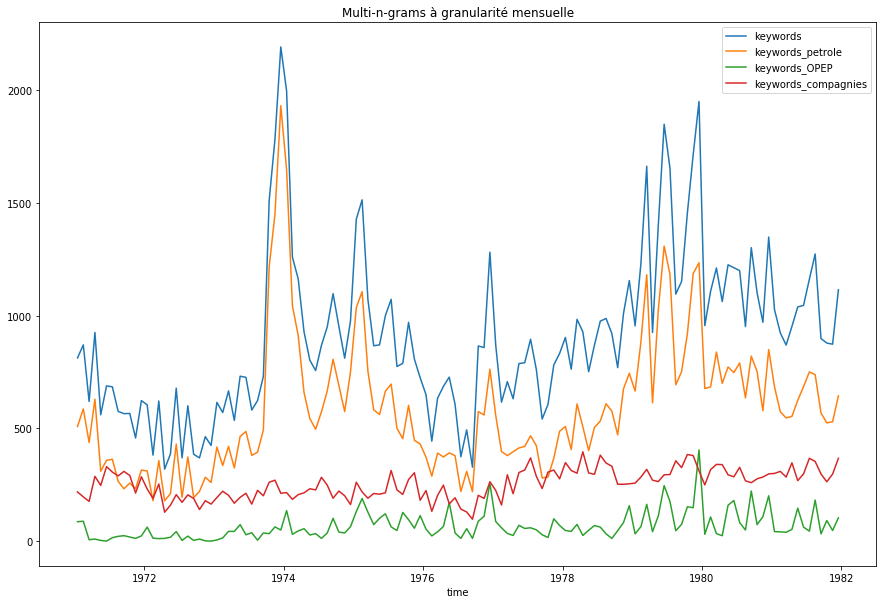

In [34]:
df_corpus_per_month.plot(x='time', y=['keywords', 'keywords_petrole', 'keywords_OPEP', 'keywords_compagnies'],
                title = 'Multi-n-grams à granularité mensuelle', figsize=(15,10), sharex=False);